In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

from copy import deepcopy

import time

import tqdm

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

In [3]:
#outdir = '../../output/experiment'
outdir = './output/synthetic/univariate/abrupt_mixture'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [4]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [5]:
def compute_tau(X, theta, eps=1e-8):
    N = X.shape[0]
    K = len(theta.pi)
    #print('N =', N, ' K =', K)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], theta.sigma[k])
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    
    #tau /= np.sum(tau, axis=1, keepdims=True)
    tau /= (np.sum(tau, axis=1, keepdims=True) + eps)
    
    tau[np.all(np.isnan(tau), axis=1), :] = np.ones(tau.shape[1])/tau.shape[1]
    
    return tau

In [6]:
"""
def compute_tau(X, theta, eps=1e-8):
    N = X.shape[0]
    K = len(theta.pi)
    #print('N =', N, ' K =', K)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], theta.sigma[k])
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    
    #tau /= np.sum(tau, axis=1, keepdims=True)
    tau /= (np.sum(tau, axis=1, keepdims=True) + eps)
    
    tau[np.all(np.isnan(tau), axis=1), :] = np.ones(tau.shape[1])/tau.shape[1]
    
    return tau
"""

"\ndef compute_tau(X, theta, eps=1e-8):\n    N = X.shape[0]\n    K = len(theta.pi)\n    #print('N =', N, ' K =', K)\n\n    tau = np.zeros((N, K))\n    for k in range(K):\n        d_k = norm(theta.mu[k], theta.sigma[k])\n        for i in range(N):\n            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])\n    \n    #tau /= np.sum(tau, axis=1, keepdims=True)\n    tau /= (np.sum(tau, axis=1, keepdims=True) + eps)\n    \n    tau[np.all(np.isnan(tau), axis=1), :] = np.ones(tau.shape[1])/tau.shape[1]\n    \n    return tau\n"

In [7]:
def compute_stat(X, Z):
    K = Z.shape[1]
    D = X.shape[1]
    
    print(f'K = {K}, D = {D}')

    #s1 = np.sum(Z, axis=0)
    s1 = np.sum(Z, axis=0, keepdims=True).reshape(-1, 1)
    #s2 = X.T.dot(Z).ravel()
    s2 = X.T.dot(Z).T
    #s3 = (X**2).T.dot(Z).ravel()
    s3 = (X**2).T.dot(Z).T.reshape(K, D, D)
    
    return s1, s2, s3

In [8]:
"""
def compute_stat(X, Z):
    N = X.shape[0]
    K = Z.shape[1]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0, keepdims=True)
    s2 = X.T.dot(Z).T
    s3 = np.einsum('ijk,il->ljk' , np.array([np.outer(X[i, :], X[i, :])  for i in range(X.shape[0])]), Z)
    
    return s1, s2, s3
"""

"\ndef compute_stat(X, Z):\n    N = X.shape[0]\n    K = Z.shape[1]\n    D = X.shape[1]\n\n    s1 = np.sum(Z, axis=0, keepdims=True)\n    s2 = X.T.dot(Z).T\n    s3 = np.einsum('ijk,il->ljk' , np.array([np.outer(X[i, :], X[i, :])  for i in range(X.shape[0])]), Z)\n    \n    return s1, s2, s3\n"

In [9]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    #mu = s.s2 / (s.s1 + eps)
    mu = s.s2 / (s.s1.reshape(-1, 1) + eps)
    """
    print('step_M')
    print('s.s3:', s.s3.shape)
    print('s.s1.reshape((len(s.s1), ) + (1, 1)):', s.s1.reshape((len(s.s1), ) + (1, 1)).shape)
    print('np.sqrt(s.s1.reshape((len(s.s1), ) + (1, 1)) + eps) - mu**2:', 
          (np.sqrt(s.s1.reshape((len(s.s1), ) + (1, 1)) + eps) - mu.reshape((len(s.s1), ) + (1, 1))**2).shape)
    """
    #sigma = np.sqrt(s.s3 / (s.s1.reshape((len(s.s1), ) + (1, 1)) + eps) - mu**2)
    sigma = np.sqrt(s.s3 / (s.s1.reshape((len(s.s1), ) + (1, 1)) + eps) - mu.reshape((len(s.s1), ) + (1, 1))**2)
    
    return pi, mu, sigma

In [10]:
"""
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)

    return pi, mu, sigma
"""

"\ndef step_M(s, x, eps=1e-8):\n    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))\n    mu = s.s2 / (s.s1 + eps)\n    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)\n\n    return pi, mu, sigma\n"

In [11]:
"""
class SuffStat:
    def __init__(self):
        pass

class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.random(K)
        #self.s2 = np.random.random(K)
        self.s2 = np.random.random((K, D))
        #self.s3 = np.random.random(K)
        self.s3 = np.random.random((K, D, D))
        #self.s3 = np.array([make_spd_matrix(D) for _ in range(K)])
"""

'\nclass SuffStat:\n    def __init__(self):\n        pass\n\nclass SuffStatGMM(SuffStat):\n    def __init__(self, K, D, seed=0):\n        super().__init__()\n        np.random.seed(seed)\n        self.s1 = np.random.random(K)\n        #self.s2 = np.random.random(K)\n        self.s2 = np.random.random((K, D))\n        #self.s3 = np.random.random(K)\n        self.s3 = np.random.random((K, D, D))\n        #self.s3 = np.array([make_spd_matrix(D) for _ in range(K)])\n'

In [12]:
class SuffStat:
    def __init__(self):
        pass

class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))

In [13]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [14]:
class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0] # \overline{\gamma}_i^{(t)} in the paper
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [15]:
def calc_scores_sdem(X, r, n_cluster, alpha=1.0, start=20, end=40, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=n_cluster)

    X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    
    sdem.fit(X_init)

    for t in range(X.shape[0]):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    #pi_est = np.array(sdem.weights_)
    mu_est = np.array(sdem.means_bar_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * start
    
    #for t in range(start, pi_est.shape[0]):
    for t in range(start, X.shape[0]):
        p = np.zeros(n_cluster)
        if n_cluster >= 2:
            for k in range(n_cluster):
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
                p[k] = p_k
        else:
            p[0] = pi_est[t-1] * norm(mu_est[t-1, 0, :], np.sqrt(sigma_est[t-1, :, :])).pdf(X[t, :])
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(1e-30))
    scores = np.array(scores)
    
    return scores

In [16]:
def calc_scores_iem(X, n_cluster, alpha=1.0, start=20, end=40, seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    #sdem = SDEM(rhos, alpha, n_components=k)
    sdem = SDEM(rhos, alpha, n_components=n_cluster)

    xmin = np.min(X[start:end, :])
    xmax = np.max(X[start:end, :])
    
    X_init = np.random.uniform(xmin, xmax, 20).reshape(20, X.shape[1])
    sdem.fit(X_init)
    
    for t in range(X.shape[0]):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * start

    """
    n_cluster = pi_est.shape[1]
    for t in range(start, X.shape[0]):
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(-1.0/np.finfo(np.float).min))
    scores = np.array(scores)
    """
    #for t in range(start, pi_est.shape[0]):
    for t in range(start, X.shape[0]):
        p = np.zeros(n_cluster)
        if n_cluster >= 2:
            for k in range(n_cluster):
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
                p[k] = p_k
        else:
            p[0] = pi_est[t-1] * norm(mu_est[t-1, 0, :], np.sqrt(sigma_est[t-1, :, :])).pdf(X[t, :])
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(1e-30))
    scores = np.array(scores)
    
    return scores

In [108]:
def sem(X, theta0, rho, start, end, seed):
    np.random.seed(seed)
    
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    theta = deepcopy(theta0)
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    #X_init = np.random.uniform(-2, 2, 20).reshape(-1, X.shape[1])
    #X_init = X[start:end, :].reshape(-1, X.shape[1])
    X_init = X[:10, :].reshape(-1, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)

    
    inds = np.arange(N)
    
    for n in range(start, N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        if K == 1:
            s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new.ravel() - s.s2)
            s.s3 += rho[n] * (s3_indiv_new.ravel() - s.s3)
        else:
            """
            print('tau_indiv_new:', tau_indiv_new.shape)
            print('s.s1:', s.s1.shape)
            print('s2_indiv_new:', s2_indiv_new.shape)
            print('s.s2:', s.s2.shape)
            print('s3_indiv_new:', s3_indiv_new.shape)
            print('s.s3:', s.s3.shape)
            """
            s.s1 += rho[n] * (tau_indiv_new - s.s1)
            #s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new - s.s2)
            s.s3 += rho[n] * (s3_indiv_new - s.s3)

        # M-step
        """
        print(step_M(s, 1))
        print(theta.pi.shape)
        print(step_M(s, X[ind_n, :])[0])
        print(theta.mu.shape)
        print(step_M(s, X[ind_n, :])[1])
        print(theta.sigma.shape)
        print(step_M(s, X[ind_n, :])[2])
        """
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est

In [93]:
def calc_scores_sem(X, theta0, r, k, start=20, end=40, seed=0):
    rho_const = np.repeat([r], X.shape[0])
    pi_est, mu_est, sigma_est = sem(X, theta0, rho_const, start, end, seed)
    
    #plt.plot(X.ravel())
    #plt.plot(mu_est.ravel(), linestyle='dashed')
    #plt.show()
    
    scores = [np.nan]*start
    for t in range(start, pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(1e-30))
            
    return scores


In [109]:
def sra(X, theta0, rho, gamma, t_start=50, start=20, end=40):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(20, X.shape[1])
    #X_init = np.random.uniform(-2, 2, 20).reshape(20, X.shape[1])
    #X_init = X[start:end, :].reshape(-1, X.shape[1])
    X_init = X[:10, :].reshape(-1, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)

    outliers = []
    
    inds = np.arange(N)
    
    for n in range(start, N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        #tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        """
        print('s3_indiv_new:', s3_indiv_new.shape)
        """
        
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            
            outliers.append(n)
            
            continue
            
        # update the statistics
        if K == 1:
            s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new.ravel() - s.s2)
            s.s3 += rho[n] * (s3_indiv_new.ravel() - s.s3)
        else:
            """
            print('tau_indiv_new:', tau_indiv_new.shape)
            print('s.s1:', s.s1.shape)
            print('s2_indiv_new:', s2_indiv_new.shape)
            print('s.s2:', s.s2.shape)
            print('s3_indiv_new:', s3_indiv_new.shape)
            print('s.s3:', s.s3.shape)
            """
            s.s1 += rho[n] * (tau_indiv_new - s.s1)
            s.s2 += rho[n] * (s2_indiv_new - s.s2)
            s.s3 += rho[n] * (s3_indiv_new - s.s3)

        # M-step
        """
        print(theta.pi.shape)
        print(step_M(s, X[ind_n, :])[0])
        print(theta.mu.shape)
        print(step_M(s, X[ind_n, :])[1])
        print(theta.sigma.shape)
        print(step_M(s, X[ind_n, :])[2])
        """
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    return pi_est, mu_est, sigma_est, outliers

In [110]:
def calc_scores_sra(X, theta0, k, gamma, ratio, M, t_start=1500, start=20, seed=0):
    np.random.seed(seed)
    
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    pi_est, mu_est, sigma_est, outliers = sra(X, theta0, rho_const, gamma, t_start=t_start, start=start)
        
    scores = [np.nan] * start
    for t in range(start, pi_est.shape[0]):
        if t in outliers:
            score_t = np.nan
        else:
            p = np.zeros(k)
            for i in range(k):
                p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
                p[i] = p_i
            p_tot = np.sum(p)
            if p_tot >= 1e-16:
                score_t = -np.log(p_tot)
            else:
                score_t = -np.log(1e-30)
        scores.append(score_t)
    return scores

In [21]:
def calc_metrics(means, mu1, mu2, eval_start=500, eval_end=1000, burnin=1000, N=10000):
    ev = np.sum((means[eval_start:eval_end, :] - mu1)**2, axis=1)
    former = np.sum((means[burnin:N, :] - mu1)**2, axis=1)
    latter = np.sum((means[N:, :] - mu2)**2, axis=1)
    overall = np.hstack((former, latter))
    
    #return np.mean(ev), np.mean(former), np.mean(latter), np.mean(overall)
    return np.nanmean(ev), np.nanmean(former), np.nanmean(latter), np.nanmean(overall)

In [22]:
def calc_falarms_benefit(scores, change_points, start=None, end=None, T=100, N_thr=100, eps=1e-2):
    scores_max, scores_min = np.nanmax(scores), np.nanmin(scores)
    threshold_list = np.linspace(scores_min - eps, scores_max + eps, N_thr)

    falarms = []
    benefits = []
    
    N = len(scores)
    
    for threshold in threshold_list:
        binary_alarm = (np.array(scores) >= threshold)
        
        benefit = np.zeros(N)
        for cp in change_points:
            if cp < T:
                # t = 0, ... , cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(cp, 0, -1), np.arange(T)))/T
                benefit[:(cp+T)] = values
            elif cp+T > N:
                # t = cp-T, ..., cp, cp+1, ..., N-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(N-cp)))/T
                benefit[(cp-T):] = values
            else:
                # t = cp-T, ..., cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(T)))/T
                benefit[(cp-T):(cp+T)] = values
            
        if start is not None:
            if end is not None:
                benefit = benefit[start:end]
                binary_alarm = binary_alarm[start:end]
            else:
                benefit = benefit[start:]
                binary_alarm = binary_alarm[start:]
        elif end is not None:
            benefit = benefit[:end]
            binary_alarm = binary_alarm[:end]
        
        total_benefit = np.sum(binary_alarm * benefit)
        n_falarm = np.sum(binary_alarm * (benefit == 0.0).astype(np.int))
        
        benefits.append(total_benefit/np.sum(benefit))
        falarms.append(n_falarm/np.sum(benefit == 0.0))

    benefits = np.array(benefits)    
    falarms = np.array(falarms)
    
    return falarms, benefits

In [23]:
def calc_auc_main(scores, cps, start, end, T, N_thr=100):
    falarms, benefits = calc_falarms_benefit(scores, cps, start=start, end=end, T=T, N_thr=N_thr)
    auc_ = auc(falarms, benefits)

    return auc_

## MSE

In [24]:
def experiment1_comparison_mse(
    # SDEM
    r_list_sdem=[0.0001, 0.001, 0.005, 0.01], 
    # SEM
    r_list_sem=[0.01, 0.05, 0.1],
    # SRA
    gamma_list_sra=[1, 3, 5, 10, 15], 
    u=10, 
    N=10000,
    alpha_ol=0.01, # ratio of outliers
    eval_start=500,
    eval_end=1000,
    burnin=1000, 
    pi=np.array([0.5, 0.5]),
    mu1=np.array([0.5, -0.5]),
    mu2=np.array([1.0, -1.0]),
    sigma = np.array([0.1, 0.1]),
    cps=np.array([9999]),
    start=0, 
    end=None,
    T=100,
    N_thr=1000,
    n_trial=10):

    mse_sdem_eval, mse_sdem_former, mse_sdem_latter, mse_sdem_total = [], [], [], []
    mse_iem_eval, mse_iem_former, mse_iem_latter, mse_iem_total = [], [], [], []
    mse_sem_eval, mse_sem_former, mse_sem_latter, mse_sem_total = [], [], [], []
    mse_sra_eval, mse_sra_former, mse_sra_latter, mse_sra_total = [], [], [], []
    
    for trial in tqdm.tqdm(range(n_trial)):
        # generate data
        np.random.seed(trial)
        X = np.zeros((2*N, 1))
        Xj_former = generate_data(N, pi, mu1, sigma)
        X[:N, 0] = Xj_former.ravel()
        Xj_latter = generate_data(N, pi, mu2, sigma)
        X[N:, 0] = Xj_latter.ravel()

        #idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
        idxes_ol = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
        X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)    
        
        print('# SDEM')
        for i, r in enumerate(r_list_sdem):
            rho_const = np.repeat([r], 2*N)
            sdem = SDEM(rho_const, 1.0, n_components=2)
            #seed = i*len(r_list_sdem) + trial
            sdem.fit(X[:10, :])
            for t in range(X.shape[0]):
                sdem.update(X[t, :])
            
            means_est_sdem = np.array(sdem.means_list).reshape(2*N, 2)
            ev, former, latter, total = calc_metrics(means_est_sdem, mu1, mu2, eval_start, eval_end, burnin)
            mse_sdem_eval.append([trial, r, ev])
            mse_sdem_former.append([trial, r, former])
            mse_sdem_latter.append([trial, r, latter])
            mse_sdem_total.append([trial, r, total])
            
        print('# IEM')
        iem = SDEM(1.0/np.arange(1, 2*N+1), 1.0, n_components=2)
        iem.fit(X[:10, :])
        for t in range(X.shape[0]):
            iem.update(X[t, :])

        means_est_iem = np.array(iem.means_list).reshape(2*N, 2)
        ev, former, latter, total = calc_metrics(means_est_iem, mu1, mu2, eval_start, eval_end, burnin)
        mse_iem_eval.append([trial, ev])
        mse_iem_former.append([trial, former])
        mse_iem_latter.append([trial, latter])
        mse_iem_total.append([trial, total])
        
        print('# SEM')
        for i, r in enumerate(r_list_sem):
            seed = i*len(r_list_sem) + trial
            #np.random.seed(seed)
            
            rho_const = np.repeat([r], 2*N)
            
            pi0 = np.array([1.0]).reshape(-1, 1)
            X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20).reshape(20, X.shape[1])
            
            mu0 = [np.mean(X_init)]
            sigma0 = np.array([[np.std(X_init)]])
            theta0 = Theta(pi0, mu0, sigma0)

            _, means_est_sem, _ = sem(X, theta0, rho_const, start, end, seed)
            
            #ev, former, latter, total = calc_metrics(theta_est_sem[:, 3:5], mu1, mu2, eval_start, eval_end, burnin)
            ev, former, latter, total = calc_metrics(means_est_sem.reshape(
                                                        means_est_sem.shape[0], 
                                                        means_est_sem.shape[1]
                                                     ), 
                                                     mu1, mu2, eval_start, eval_end, burnin)
            mse_sem_eval.append([trial, r, ev])
            mse_sem_former.append([trial, r, former])
            mse_sem_latter.append([trial, r, latter])
            mse_sem_total.append([trial, r, total])

        print('# SRA')
        for j, gamma in enumerate(gamma_list_sra):
            ratio_list = [0.01*gamma, 0.03*gamma, 0.05*gamma, 0.1*gamma]
            M_list = [gamma, 2*gamma, 4*gamma]
            for l, ratio in enumerate(ratio_list):
                for m, M in enumerate(M_list):
                    seed = j*len(gamma_list_sra) + l*len(ratio_list) + m * len(M_list) + trial
                    
                    np.random.seed(seed)
                    rho = ratio/(2.0*gamma) * np.exp(-gamma**2/M**2)
                    rho_const = np.repeat([rho], 2*N)
                    #theta_est_sra = sra(X, theta0, rho_const, gamma)
                    _, means_est_sra, _, _ = sra(X, theta0, rho_const, gamma)
        
                    #ev, former, latter, total = calc_metrics(theta_est_sra[:, 3:5], mu1, mu2, eval_start, eval_end, burnin)
                    ev, former, latter, total = calc_metrics(
                                                    means_est_sra.reshape(
                                                        means_est_sra.shape[0], means_est_sra.shape[1]
                                                    ), 
                                                    mu1, mu2, eval_start, eval_end, burnin)
                    mse_sra_eval.append([trial, gamma, ratio, M, ev])
                    mse_sra_former.append([trial, gamma, ratio, M, former])
                    mse_sra_latter.append([trial, gamma, ratio, M, latter])
                    mse_sra_total.append([trial, gamma, ratio, M, total])
                    #former = np.sum((theta_est_sra[burnin:N+1, 3:5] - mu1)**2, axis=1)
                    #mse_sra_former.append([trial, gamma, ratio, M, former])
        
                    #latter = np.sum((theta_est_sra[N+1:, 3:5] - mu2)**2, axis=1)
                    #mse_sra_latter.append([trial, gamma, ratio, M, latter])
        
                    #overall = np.hstack((former, latter))
                    #mse_sra_total.append([trial, gamma, ratio, M, overall])

    mse_sdem_eval_df = pd.DataFrame(mse_sdem_eval, columns=['trial', 'r', 'mse'])
    mse_sdem_former_df = pd.DataFrame(mse_sdem_former, columns=['trial', 'r', 'mse'])
    mse_sdem_latter_df = pd.DataFrame(mse_sdem_latter, columns=['trial', 'r', 'mse'])
    mse_sdem_total_df = pd.DataFrame(mse_sdem_total, columns=['trial', 'r', 'mse'])

    mse_iem_eval_df = pd.DataFrame(mse_iem_eval, columns=['trial', 'mse'])
    mse_iem_former_df = pd.DataFrame(mse_iem_former, columns=['trial', 'mse'])
    mse_iem_latter_df = pd.DataFrame(mse_iem_latter, columns=['trial', 'mse'])
    mse_iem_total_df = pd.DataFrame(mse_iem_total, columns=['trial', 'mse'])

    mse_sem_eval_df = pd.DataFrame(mse_sem_eval, columns=['trial', 'r', 'mse'])
    mse_sem_former_df = pd.DataFrame(mse_sem_former, columns=['trial', 'r', 'mse'])
    mse_sem_latter_df = pd.DataFrame(mse_sem_latter, columns=['trial', 'r', 'mse'])
    mse_sem_total_df = pd.DataFrame(mse_sem_total, columns=['trial', 'r', 'mse'])

    mse_sra_eval_df = pd.DataFrame(mse_sra_eval, columns=['trial', 'gamma', 'ratio', 'M',  'mse'])
    mse_sra_former_df = pd.DataFrame(mse_sra_former, columns=['trial', 'gamma', 'ratio', 'M',  'mse'])
    mse_sra_latter_df = pd.DataFrame(mse_sra_latter, columns=['trial', 'gamma', 'ratio', 'M',  'mse'])
    mse_sra_total_df = pd.DataFrame(mse_sra_total, columns=['trial', 'gamma', 'ratio', 'M',  'mse'])


    return mse_sdem_eval_df, mse_sdem_former_df, mse_sdem_latter_df, mse_sdem_total_df, \
           mse_iem_eval_df, mse_iem_former_df, mse_iem_latter_df, mse_iem_total_df, \
           mse_sem_eval_df, mse_sem_former_df, mse_sem_latter_df, mse_sem_total_df, \
           mse_sra_eval_df, mse_sra_former_df, mse_sra_latter_df, mse_sra_total_df

In [25]:
N = 10000
alpha_ol = 0.01
pi = np.array([0.5, 0.5])
mu1 = np.array([0.5, -0.5])
mu2 = np.array([1.0, -1.0])
sigma = np.array([0.1, 0.1])
cps = np.array([9999])

u = 20
r = 0.005

X = np.zeros((2*N, 1))
Xj_former = generate_data(N, pi, mu1, sigma)
X[:N, 0] = Xj_former.ravel()
Xj_latter = generate_data(N, pi, mu2, sigma)
X[N:, 0] = Xj_latter.ravel()

#idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
idxes_ol = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)    

#idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
idxes_ol = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)    

rho_const = np.repeat([r], 2*N)
sdem = SDEM(rho_const, 1.0, n_components=2)
#seed = i*len(r_list_sdem) + trial
sdem.fit(X[:10, :])
for t in range(X.shape[0]):
    sdem.update(X[t, :])

means_est_sdem = np.array(sdem.means_list).reshape(2*N, 2)

# SDEM


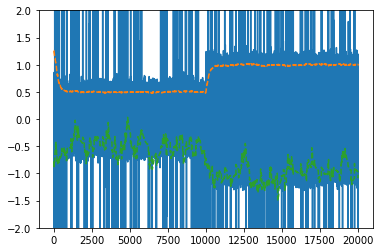

In [26]:
plt.plot(np.arange(1, 2*N+1), X.ravel())
plt.plot(np.arange(1, 2*N+1), means_est_sdem[:, 0], linestyle='dashed')
plt.plot(np.arange(1, 2*N+1), means_est_sdem[:, 1], linestyle='dashed')
plt.ylim(-2, 2)
plt.show()

In [27]:
np.mean((means_est_sdem[:500, 0] - 0.5)**2 + (means_est_sdem[:500, 1] + 0.5)**2), \
np.mean((means_est_sdem[500:1000, 0] - 0.5)**2 + (means_est_sdem[500:1000, 1] + 0.5)**2), \
np.mean((means_est_sdem[1000:N, 0] - 0.5)**2 + (means_est_sdem[1000:N, 1] + 0.5)**2), \
np.mean((means_est_sdem[N:, 0] - 1.0)**2 + (means_est_sdem[N:, 1] + 1.0)**2)

(0.21473979713338565,
 0.011268386368725757,
 0.02787210721627138,
 0.028520093117014)

In [28]:
iem = SDEM(1.0/np.arange(1, 2*N+1), 1.0, n_components=2)
iem.fit(X[:10, :])
for t in range(X.shape[0]):
    iem.update(X[t, :])

means_est_iem = np.array(iem.means_list).reshape(2*N, 2)

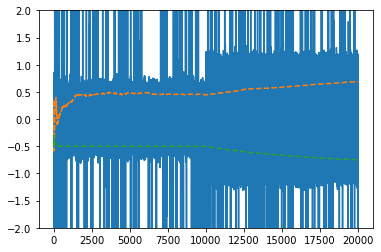

In [29]:
plt.plot(np.arange(1, 2*N+1), X.ravel())
plt.plot(np.arange(1, 2*N+1), means_est_iem[:, 0], linestyle='dashed')
plt.plot(np.arange(1, 2*N+1), means_est_iem[:, 1], linestyle='dashed')
plt.ylim(-2, 2)
plt.show()

In [30]:
np.mean((means_est_iem[:500, 0] - 0.5)**2 + (means_est_iem[:500, 1] + 0.5)**2), \
np.mean((means_est_iem[500:1000, 0] - 0.5)**2 + (means_est_iem[500:1000, 1] + 0.5)**2), \
np.mean((means_est_iem[1000:N, 0] - 0.5)**2 + (means_est_iem[1000:N, 1] + 0.5)**2), \
np.mean((means_est_iem[N:, 0] - 1.0)**2 + (means_est_iem[N:, 1] + 1.0)**2)

(0.2117468248020325,
 0.06586639790850693,
 0.0028682550798291673,
 0.3019493226933155)

In [111]:
r = 0.01
start = 20
end = X.shape[0]

seed = 2

rho_const = np.repeat([r], 2*N)

pi0 = np.array([0.5, 0.5]).reshape(-1, 1)
#pi0 = np.array([0.5, 0.5])
#X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20).reshape(20, X.shape[1])
X_init = np.random.uniform(-2, 2, 20).reshape(20, X.shape[1])

#mu0 = [np.mean(X_init)]
mu0 = np.random.uniform(np.min(X_init), np.max(X_init), 2).reshape(-1, 1)
sigma0 = np.array([[[np.std(X_init)]], [[np.std(X_init)]]])
theta0 = Theta(pi0, mu0, sigma0)

_, means_est_sem, _ = sem(X, theta0, rho_const, start, end, seed)

K = 2, D = 1


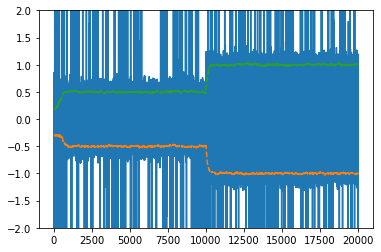

In [112]:
plt.plot(np.arange(1, 2*N+1), X.ravel())
plt.plot(np.arange(1, 2*N+1), means_est_sem[:, 0], linestyle='dashed')
plt.plot(np.arange(1, 2*N+1), means_est_sem[:, 1], linestyle='dashed')
plt.ylim(-2, 2)
plt.show()

In [113]:
np.mean((means_est_sem[20:500, 0] - 0.5)**2 + (means_est_sem[20:500, 1] + 0.5)**2), \
np.mean((means_est_sem[500:1000, 0] - 0.5)**2 + (means_est_sem[500:1000, 1] + 0.5)**2), \
np.mean((means_est_sem[1000:N, 0] - 0.5)**2 + (means_est_sem[1000:N, 1] + 0.5)**2), \
np.mean((means_est_sem[N:, 0] - 1.0)**2 + (means_est_sem[N:, 1] + 1.0)**2)

(1.2405412448848627, 1.8477811276638678, 2.0018450965280294, 7.954680385575249)

In [114]:
theta0.mu

array([[-1.36956728],
       [ 1.70235614]])

In [115]:
#gamma = 3.0
#ratio = 0.3
#M = 10.0
gamma = 3.0
ratio = 0.3
M = 10.0

seed = 0

np.random.seed(seed)
rho = ratio/(2.0*gamma) * np.exp(-gamma**2/M**2)
rho_const = np.repeat([rho], 2*N)

#theta_est_sra = sra(X, theta0, rho_const, gamma)
_, means_est_sra, _, _ = sra(X, theta0, rho_const, gamma)

K = 2, D = 1


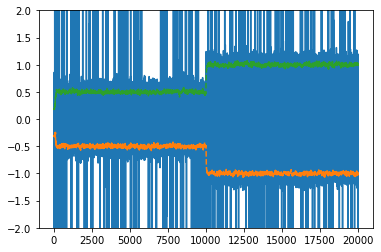

In [116]:
plt.plot(np.arange(1, 2*N+1), X.ravel())
plt.plot(np.arange(1, 2*N+1), means_est_sra[:, 0, :], linestyle='dashed')
plt.plot(np.arange(1, 2*N+1), means_est_sra[:, 1, :], linestyle='dashed')
plt.ylim(-2, 2)
plt.show()

In [117]:
np.mean((means_est_sra[20:500, 0] - 0.5)**2 + (means_est_sra[20:500, 1] + 0.5)**2), \
np.mean((means_est_sra[500:1000, 0] - 0.5)**2 + (means_est_sra[500:1000, 1] + 0.5)**2), \
np.mean((means_est_sra[1000:N, 0] - 0.5)**2 + (means_est_sra[1000:N, 1] + 0.5)**2), \
np.mean((means_est_sra[N:, 0] - 1.0)**2 + (means_est_sra[N:, 1] + 1.0)**2)

(1.835352379364982, 1.9927298437385519, 2.0019343157268885, 7.987573233165228)

In [41]:
mse_sdem_eval_df, mse_sdem_former_df, mse_sdem_latter_df, mse_sdem_total_df, \
mse_iem_eval_df, mse_iem_former_df, mse_iem_latter_df, mse_iem_total_df, \
mse_sem_eval_df, mse_sem_former_df, mse_sem_latter_df, mse_sem_total_df, \
mse_sra_eval_df, mse_sra_former_df, mse_sra_latter_df, mse_sra_total_df = experiment1_comparison_mse(u=20)

  0%|          | 0/10 [00:00<?, ?it/s]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 10%|█         | 1/10 [20:00<3:00:00, 1200.02s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 20%|██        | 2/10 [39:45<2:38:52, 1191.59s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 30%|███       | 3/10 [58:54<2:16:45, 1172.24s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 40%|████      | 4/10 [1:21:01<2:03:18, 1233.10s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 50%|█████     | 5/10 [1:43:06<1:45:32, 1266.43s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 60%|██████    | 6/10 [2:05:28<1:26:07, 1291.86s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 70%|███████   | 7/10 [2:28:13<1:05:47, 1315.95s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 80%|████████  | 8/10 [2:49:56<43:43, 1311.84s/it]  

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


 90%|█████████ | 9/10 [3:12:06<21:57, 1317.58s/it]

# SDEM
# IEM
# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# SRA


100%|██████████| 10/10 [3:31:43<00:00, 1270.36s/it]


In [22]:
mse_sdem_eval_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.0001,0.543586,0.063872
0.0010,0.512158,0.020267
0.0050,0.506038,0.002850
0.0100,0.513160,0.006211


In [23]:
mse_sdem_former_df

,trial,r,mse
0,0,0.0001,0.594879
1,0,0.0010,0.505026
2,0,0.0050,0.508280
3,0,0.0100,0.516614
4,1,0.0001,0.523619
5,1,0.0010,0.501827
6,1,0.0050,0.506203
7,1,0.0100,0.513043
8,2,0.0001,0.502310
9,2,0.0010,0.501206


In [24]:
mse_sdem_former_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.0001,0.519632,0.029240
0.0010,0.501641,0.001268
0.0050,0.507183,0.001274
0.0100,0.514881,0.002035


In [25]:
mse_sdem_latter_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.0001,2.003603,0.005151
0.0010,2.002727,0.000623
0.0050,2.012804,0.002570
0.0100,2.024977,0.003736


In [26]:
mse_sdem_total_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.0001,1.300669,0.016550
0.0010,1.291686,0.000712
0.0050,1.299615,0.001690
0.0100,1.309668,0.002422


In [27]:
mse_iem_eval_df['mse'].agg(['mean', 'std'])

mean    0.502609
std     0.002225
Name: mse, dtype: float64

In [28]:
mse_iem_former_df['mse'].agg(['mean', 'std'])

mean    0.500468
std     0.000431
Name: mse, dtype: float64

In [29]:
mse_iem_latter_df['mse'].agg(['mean', 'std'])

mean    2.000169
std     0.000204
Name: mse, dtype: float64

In [30]:
mse_iem_total_df['mse'].agg(['mean', 'std'])

mean    1.289784
std     0.000267
Name: mse, dtype: float64

In [31]:
mse_sem_eval_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.01,0.556789,0.017247
0.05,0.571162,0.020360
0.10,0.647956,0.039053


In [32]:
mse_sem_former_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.01,0.514875,0.002031
0.05,0.579654,0.006668
0.10,0.667569,0.015274


In [33]:
mse_sem_latter_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.01,2.024977,0.003736
0.05,2.122123,0.008148
0.10,2.246181,0.013319


In [34]:
mse_sem_total_df.groupby('r')['mse'].agg(['mean', 'std'])

,mean,std
r,,
0.01,1.309666,0.002420
0.05,1.391480,0.003828
0.10,1.498417,0.005933
